# Example: Binary Bernoulli Bandit Problem
In this example, we'll construct and solve the Binary Bernoulli Bandit Problem with and without context using the $\epsilon$-Greedy solution algorithm for a temperature guessing application.

* __Game__: Each bandit will have three arms. We fit a distribution to observed temperature data within a specific context, e.g., location and time of year. For each round, we sample the temperature distribution. If $T > \mu + \sigma$, arm `1` will return true. If $T < \mu - \sigma$, arm `3` will return true. Otherwise, for $T$ between $\mu\pm\sigma$, arm `2` will return true.
* _Expectation_: Depending upon the shape of the distribution, if we are [Normally distributed](https://en.wikipedia.org/wiki/Normal_distribution), we expect to see that arm `2` will have a peak near `0.68` while arms `1` and `3` will have peaks near `0.16`.
  

## $\epsilon$-Greedy Binary Bernoulli Bandit
The $\epsilon$-greedy algorithm is simple and effective for solving the binary Bernoulli bandit problem. The algorithm selects the _best action_ with probability $1-\epsilon$ and selects a random action with probability $\epsilon$. The pseudo-code for the $\epsilon$-greedy algorithm is given below [(with more detail version can be found here)](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-7/L7c/docs/BBBPcode.pdf):

### Pseudo-code
The agent has $K$ arms (choices), $\mathcal{A} = \left\{1,2,\dots,K\right\}$, and the total number of rounds is $T\gg{K}$. Initialize the parameters of [the Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) for each arm $a\in\mathcal{A}$ to $\alpha_{a} = 1$ and $\beta_{a} = 1$. The agent uses the following algorithm to choose which arm to pull (which action to take) during each round:

For $t = 1,2,\dots,T$:
1. _Initialize_: Roll a random number $p\in\left[0,1\right]$ and compute a threshold $\epsilon_{t}={t^{-1/3}}\cdot\left(K\cdot\log(t)\right)^{1/3}$.
2. _Exploration_: If $p\leq\epsilon_{t}$, choose a random (uniform) arm $a_{t}\in\mathcal{A}$. Execute the action $a_{t}$ and receive a reward $r_{t} = \left\{0,1\right\}$ from the _adversary_ (nature). 
3. _Exploitation_: Else if $p>\epsilon_{t}$, choose action $a^{\star}_{t}$, the action with the _highest expected probability of success_ (still a greedy choice), using the agents model of the world. Execute the action $a^{\star}_{t}$ and recieve a reward $r^{\star}_{t}\in\left\{0,1\right\}$ from the _adversary_ (nature). 
    - We generate the highest probability estimate of success by sampling from the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) for each arm: $\mathbf{p}\gets\left\{\text{Beta}(1+\mathbf{S}(a),1+\mathbf{F}(a))\mid\forall{a}\in\mathcal{A}\right\}$ where $\mathbf{S}(a)$ and $\mathbf{F}(a)$ are the number of successes and failures for arm $a$. The highest probability action is: $a^{\star} = \text{argmax}_{a\in\mathcal{A}}\left\{\mathbf{p}(a)\right\}$.
4. Update the success $\mathbf{S}(a^{\star})$ and failure $\mathbf{F}(a^{\star})$ arrays for the chosen arm $a^{\star}_{t}$ using the reward $r^{\star}_{t}$:
$$
\begin{equation*}
S(a^{\star}_{t}) \gets S(a^{\star}_{t}) + r^{\star}_{t},\quad F(a^{\star}_{t}) \gets F(a^{\star}_{t}) + (1-r^{\star}_{t})
\end{equation*}
$$

Using a model of the world allows the agent to make _probabilistic_ decisions about which actions to take. This is the essence of the Bayesian approach to bandit problems. The agent has a model of likely reward distribution for _each_ action and uses this model to select the best action at each time step.

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [3]:
include("Include.jl");

### Data
Let's load the three datasets we will use to train the bandits. We've downloaded weather datasets from [the National Weather Service](https://www.weather.gov) using the `Past Weather` functionality for [Ithaca, NY in Jan 2025](https://www.cityofithaca.org/), [Tracy, CA in Jan 2025](https://www.cityoftracy.org/) and [St. George, UT in July 2024](https://sgcityutah.gov/).

In [5]:
dataset = let

    # initialize -
    dataset = Dict{Int64, DataFrame}();
    
    # contextual keys
    # 1 = Ithaca, NY Jan 2025
    # 2 = Tracy, CA Jan 2025
    # 3 = StGeorge, UT July 2024

    # load the data files -
    dataset[1] = CSV.read(joinpath(_PATH_TO_DATA, "Weather-Ithaca-NY-Jan-2025.csv"), DataFrame)
    dataset[2] = CSV.read(joinpath(_PATH_TO_DATA, "Weather-Tracy-CA-Jan-2025.csv"), DataFrame)
    dataset[3] = CSV.read(joinpath(_PATH_TO_DATA, "Weather-StGeorge-UT-July-2024.csv"), DataFrame)
    
    # return -
    dataset
end

Dict{Int64, DataFrame} with 3 entries:
  2 => 31×9 DataFrame…
  3 => 31×10 DataFrame…
  1 => 31×10 DataFrame…

In [6]:
dataset[1] # look at data for a key (location)

Row,Date,Max Temp,Min Temp,Avg Temp,Departure,HDD,CDD,Precipitation,New Snow,Snow Depth
,Date,Float64,Float64,Float64,Float64,Int64,Int64,String7,String3,String1
1,2025-01-01,49.0,30.0,39.5,14.6,25,0,0.1,0.0,0
2,2025-01-02,42.0,30.0,36.0,11.3,29,0,0.23,0.1,T
3,2025-01-03,34.0,26.0,30.0,5.5,35,0,T,T,0
4,2025-01-04,29.0,21.0,25.0,0.7,40,0,0.01,0.1,T
5,2025-01-05,24.0,20.0,22.0,-2.1,43,0,T,T,T
6,2025-01-06,25.0,20.0,22.5,-1.4,42,0,T,T,T
7,2025-01-07,21.0,11.0,16.0,-7.7,49,0,0.03,0.5,1
8,2025-01-08,20.0,15.0,17.5,-6.0,47,0,0.03,0.9,1
9,2025-01-09,16.0,13.0,14.5,-8.9,50,0,T,0.1,1


### Context
Next, let's build context models that we'll use in our calculations.

In [8]:
contexts = let

    # initialize -
    contexts = Dict{Int,MyContextualBernoulliBanditAlgorithmWeatherContextModel}();

    for (key, data) ∈ dataset
        contexts[key] = build(MyContextualBernoulliBanditAlgorithmWeatherContextModel, (
            d = fit_mle(Normal, data[:,Symbol("Avg Temp")]),
            key = key,
            dataframe = data       
        ));
    end

    # return -
    contexts;
end

Dict{Int64, MyContextualBernoulliBanditAlgorithmWeatherContextModel} with 3 entries:
  2 => MyContextualBernoulliBanditAlgorithmWeatherContextModel(Normal{Float64}(…
  3 => MyContextualBernoulliBanditAlgorithmWeatherContextModel(Normal{Float64}(…
  1 => MyContextualBernoulliBanditAlgorithmWeatherContextModel(Normal{Float64}(…

Next, let's build the `world(...)` function that we'll use with the bandit. This function takes the time step $t$, the action $a$ from our agent, and a `context` model. It returns the reward associated with choosing this action. In this initial implementation, we do not use the context information. In this implementation of the `world(...)` function, we use a _fake_ model of the data.

In [10]:
function world(t::Int64, a::Int64, context::AbstractBanditAlgorithmContextModel)::Int64

    # initialize (fake data)
    μ = 45.0; # Average high temp in ITH in Jan
    σ = 10.0; # standard deviation -
    temp = Normal(μ,σ) |> d -> rand(d); # generate a random temperature 

    # bool questions -
    rₜ = nothing;
    if (a == 1)
        rₜ = (temp > μ + σ) ? 1 : 0; # Q: T > μ + σ
    elseif (a == 2)
        rₜ = ((temp ≤ μ + σ) && (temp ≥ μ - σ)) ? 1 : 0; # Q: Bounded between μ ± σ
    elseif (a == 3)
        rₜ = (temp < μ - σ) ? 1 : 0; # Q: T < μ - σ
    end
    rₜ # return 
end

world (generic function with 1 method)

In [11]:
function Location(t::Int64, a::Int64, context::MyContextualBernoulliBanditAlgorithmWeatherContextModel)::Int64

    # get model for Ithaca - 
    d = context.d;
    μ = params(d)[1]; # mean
    σ = params(d)[2]; # std -

    # bool questions -
    rₜ = nothing;
    temp = rand(d);
    if (a == 1)
        rₜ = (temp > μ + σ) ? 1 : 0; # Q: T > μ + σ
    elseif (a == 2)
        rₜ = ((temp ≤ μ + σ) && (temp ≥ μ - σ)) ? 1 : 0; # Q: Bounded between μ ± σ
    elseif (a == 3)
        rₜ = (temp < μ - σ) ? 1 : 0; # Q: T < μ - σ
    end
    rₜ # return 
end

Location (generic function with 1 method)

### Constants
Finally, let's set some constants we'll use in the subsequent tasks. See the comment beside the value for a description of what it is, its permissible values, etc.

In [13]:
K = 3; # number of arms for the bandit
T = 1000; # number of rounds for each decision task

## Learn the weather without context
We create an [instance of the `MyBinaryBanditGreedyAlgorithmModel` type](src/Types.jl) which holds the number of arms `K` using [a `build(...)` method](src/Factory.jl). To solve the problem, we pass the model [to the `solve(...)` method](src/Bandit.jl), which returns the output from the game.
* __Output__: Each of [the `solve(...)` methods](src/Bandit.jl) returns a results array holding the records of the game. The rows of the array are the turns of the decision task, while the first column corresponds to the arm chosen, the second is the award received for that round, the third is $S(a)$ value for the chosen action, and the final column is the $F(a)$ value for the chosen action. We also output the model `m₁::MyBinaryBanditGreedyAlgorithmModel.`

In [15]:
results_eps_greedy, m₁ = let

    m = build(MyBinaryBanditGreedyAlgorithmModel, (
        K = K, # number of arms
    ));
    
    results = solve(m, T = T, world = world);
    results, m
end;

In [39]:
results_eps_greedy

1000×4 Matrix{Float64}:
 1.0  0.0    0.0    1.0
 1.0  0.0    0.0    2.0
 1.0  0.0    0.0    3.0
 3.0  0.0    0.0    1.0
 1.0  0.0    0.0    4.0
 3.0  0.0    0.0    2.0
 2.0  1.0    1.0    0.0
 3.0  0.0    0.0    3.0
 1.0  0.0    0.0    5.0
 2.0  1.0    2.0    0.0
 3.0  0.0    0.0    4.0
 2.0  1.0    3.0    0.0
 2.0  1.0    4.0    0.0
 ⋮                
 2.0  1.0  569.0  231.0
 2.0  1.0  570.0  231.0
 2.0  1.0  571.0  231.0
 2.0  1.0  572.0  231.0
 2.0  1.0  573.0  231.0
 2.0  1.0  574.0  231.0
 2.0  1.0  575.0  231.0
 2.0  1.0  576.0  231.0
 3.0  0.0   18.0   85.0
 2.0  1.0  577.0  231.0
 2.0  1.0  578.0  231.0
 2.0  0.0  578.0  232.0

In [16]:
m₁

MyBinaryBanditGreedyAlgorithmModel(3, Dict(2 => 578, 3 => 18, 1 => 12), Dict(2 => 232, 3 => 85, 1 => 75))

`Unhide` the code block below to see how we plotted the [Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) for the three arms of the contextless bandit. 

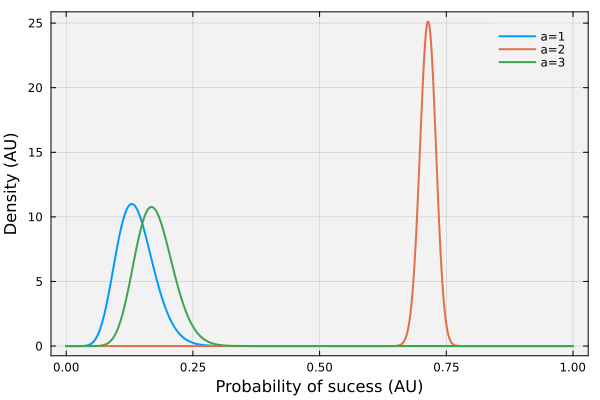

In [18]:
let

    # get parameters for the final distributions -
    (α₁,β₁) = findlast(x-> x== 1.0, results_eps_greedy[:,1]) |> i-> results_eps_greedy[i,3:end]
    (α₂,β₂) = findlast(x-> x== 2.0, results_eps_greedy[:,1]) |> i-> results_eps_greedy[i,3:end]
    (α₃,β₃) = findlast(x-> x== 3.0, results_eps_greedy[:,1]) |> i-> results_eps_greedy[i,3:end]

    # build distributions -
    d₁ = Beta(α₁,β₁);
    d₂ = Beta(α₂,β₂);
    d₃ = Beta(α₃,β₃);

    # plot -
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot!(d₁, label="a=1", lw=2);
    plot!(d₂, label="a=2", lw=2);
    plot!(d₃, label="a=3", lw=2);
    xlabel!("Probability of sucess (AU)", fontsize=18)
    ylabel!("Density (AU)", fontsize=18)
end

## Learn the weather with context
Next, let's use our context models to learn the weather in each location, which is specified by an instance of a `context` model. First, we build an instance of [the `MyContextualBernoulliBanditAlgorithmModel` type](src/Types.jl).

In [20]:
m₂ = let

    # build model -
    arms = Dict(1=>3, 2=>3, 3=>3); # each context has three arms
    keys = [1,2,3]; # order of the contexts
    context = contexts[1]; # Ithaca

    # build a model -
    m = build(MyContextualBernoulliBanditAlgorithmModel, (
        K = arms,
        keys = keys
    ));
end;

What is in [the `MyContextualBernoulliBanditAlgorithmModel` instance](src/Types.jl)?

In [22]:
m₂.bandits

Dict{Int64, MyBinaryBanditGreedyAlgorithmModel} with 3 entries:
  2 => MyBinaryBanditGreedyAlgorithmModel(3, Dict(2=>0, 3=>0, 1=>0), Dict(2=>0,…
  3 => MyBinaryBanditGreedyAlgorithmModel(3, Dict(2=>0, 3=>0, 1=>0), Dict(2=>0,…
  1 => MyBinaryBanditGreedyAlgorithmModel(3, Dict(2=>0, 3=>0, 1=>0), Dict(2=>0,…

Learn [the Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) for each context. We specify a `key,` which tells the bandit which location (in this case) we are looking at.
* __Output__: Each of [the `solve(...)` methods](src/Bandit.jl) returns a results array holding the records of the game. The rows of the array are the turns of the decision task, while the first column corresponds to the arm chosen, the second is the award received for that round, the third is $S(a)$ value for the chosen action, and the final column is the $F(a)$ value for the chosen action.
* _How is this different_? The `results_per_context` (and the associated bandit) describes the temperature range in a _specific_ context. Thus, the results array (and bandit) are customized to a specific location.

In [24]:
results_per_context, training_key = let

    key = 1; # which context?
    context = contexts[key];
    results = solve(m₂, T = T, world = Location, context = context);
    results,key
end

([2.0 1.0 1.0 0.0; 1.0 0.0 0.0 1.0; … ; 2.0 1.0 547.0 273.0; 2.0 1.0 548.0 273.0], 1)

In [41]:
results_per_context

1000×4 Matrix{Float64}:
 2.0  1.0    1.0    0.0
 1.0  0.0    0.0    1.0
 2.0  1.0    2.0    0.0
 2.0  1.0    3.0    0.0
 3.0  0.0    0.0    1.0
 2.0  0.0    3.0    1.0
 2.0  1.0    4.0    1.0
 3.0  0.0    0.0    2.0
 1.0  0.0    0.0    2.0
 2.0  0.0    4.0    2.0
 3.0  0.0    0.0    3.0
 3.0  1.0    1.0    3.0
 1.0  0.0    0.0    3.0
 ⋮                
 2.0  0.0  541.0  270.0
 2.0  1.0  542.0  270.0
 2.0  1.0  543.0  270.0
 3.0  0.0   14.0   77.0
 2.0  1.0  544.0  270.0
 2.0  1.0  545.0  270.0
 2.0  0.0  545.0  271.0
 2.0  0.0  545.0  272.0
 2.0  1.0  546.0  272.0
 2.0  0.0  546.0  273.0
 2.0  1.0  547.0  273.0
 2.0  1.0  548.0  273.0

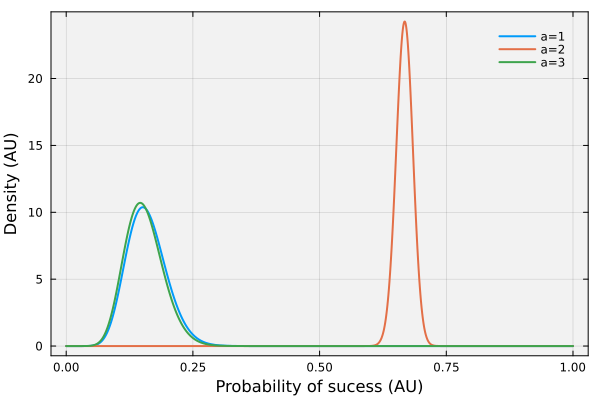

In [45]:
let

    # get parameters for the final distributions -
    (α₁,β₁) = findlast(x-> x== 1.0, results_per_context[:,1]) |> i-> results_per_context[i,3:end]
    (α₂,β₂) = findlast(x-> x== 2.0, results_per_context[:,1]) |> i-> results_per_context[i,3:end]
    (α₃,β₃) = findlast(x-> x== 3.0, results_per_context[:,1]) |> i-> results_per_context[i,3:end]

    # build distributions -
    d₁ = Beta(α₁,β₁);
    d₂ = Beta(α₂,β₂);
    d₃ = Beta(α₃,β₃);

    # plot -
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot!(d₁, label="a=1", lw=2);
    plot!(d₂, label="a=2", lw=2);
    plot!(d₃, label="a=3", lw=2);
    xlabel!("Probability of sucess (AU)", fontsize=18)
    ylabel!("Density (AU)", fontsize=18)
end